In [1]:
import numpy as np
import pandas as pd
from pylab import plt

In [2]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)


In [12]:
top_games_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_games_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 100]
top_games = list(top_games_df.index)
top_users_df = steam_df.loc[(steam_df['behavior'] == 'play') & (steam_df['game'].isin(top_games))]
top_users_df = top_users_df.groupby('user_id').agg({'game':'count'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 25]
top_users = list(top_users_df.index)
top_users_df

,game
user_id,
49893565,69
11403772,62
55906572,62
48798067,60
36546868,56
...,...
82046939,25
81591317,25
88035166,25


In [13]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

7180 5978


In [14]:
steam_df

,user_id,game,behavior,hours
133,53875128,Grand Theft Auto V,purchase,1.0
134,53875128,Grand Theft Auto V,play,86.0
135,53875128,Insurgency,purchase,1.0
136,53875128,Insurgency,play,72.0
137,53875128,Left 4 Dead 2,purchase,1.0
...,...,...,...,...
199788,135400225,Half-Life 2 Lost Coast,purchase,1.0
199794,135400225,No More Room in Hell,purchase,1.0
199796,135400225,PAYDAY The Heist,purchase,1.0
199800,135400225,Portal,purchase,1.0


In [15]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 174, Unique Games: 102


In [16]:
A = np.zeros((len(users), len(games)))
B = np.zeros((len(users), len(games)))
print(A.shape)
for i in range(len(users)):
    user = users[i]
    print(i)
    purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
    user_play_df = play_df.loc[play_df['user_id'] == user]
    played = user_play_df['game'].unique()
    hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
    for j in range(len(games)):
        game = games[j]
        A[i, j] = (hours_played[game] if game in played else 0) if game in purchased else 0
        B[i, j] = 1 if game in purchased else 0
    # entries = [(hours_played[game] if game in played else 0) if game in purchased else np.nan for game in games]
    # sparse_df = sparse_df.append([entries])

(174, 102)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173


In [22]:
np.save('steam_100.npy', A)
np.save('missing_100.npy', B)

In [18]:
class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


In [19]:
rpca = R_pca(A)
L, S = rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 62.00377747486594
iteration: 100, error: 2.5542638038720726
iteration: 200, error: 2.0982941931719603
iteration: 300, error: 0.64365629193428
iteration: 400, error: 0.4968572082668166
iteration: 500, error: 0.24243406725935193
iteration: 600, error: 0.16739115319703776
iteration: 700, error: 0.17933053147874478
iteration: 800, error: 0.20420638589324933
iteration: 900, error: 0.2037400289124598
iteration: 1000, error: 0.19718144167987275
iteration: 1100, error: 0.1812366637233397
iteration: 1200, error: 0.20622448781840677
iteration: 1300, error: 0.14208609897543753
iteration: 1400, error: 0.08791530115506091
iteration: 1500, error: 0.11703382112378889
iteration: 1600, error: 0.2878151118502335
iteration: 1700, error: 0.14446977594745533
iteration: 1800, error: 0.0368844598935838
iteration: 1900, error: 0.019938455290480758
iteration: 2000, error: 0.013475628288276621
iteration: 2100, error: 0.010155077478014054
iteration: 2200, error: 0.007907689853737097
iteratio

In [20]:
# visually inspect results (requires matplotlib)
rpca.plot_fit()
plt.show()

ymin: 0.0, ymax: 5608.0


KeyboardInterrupt: 

In [21]:
L

array([[ 2.53777704e-05,  6.06329233e-06,  7.15231704e-06, ...,
         1.41273379e-05,  2.65641253e-04,  3.21882287e+00],
       [ 4.75275636e-06,  3.53901495e-06, -1.75641958e-07, ...,
         5.40637854e-06, -3.54629743e-05, -7.32102039e-07],
       [ 3.29802332e-07,  2.85112260e-06,  2.79853848e-06, ...,
        -5.06045299e-06,  2.96932672e-05,  1.58053859e+00],
       ...,
       [ 1.15215345e-05,  4.41324880e-06,  5.12128698e-06, ...,
         8.63206082e-06,  5.69300663e-05,  1.42498321e-06],
       [-5.56638820e-06,  5.77938529e-06,  1.51942427e-05, ...,
        -6.54212334e-06,  1.75349181e-05, -2.38810588e-02],
       [ 2.49899781e-05, -9.85629641e-06,  5.85125689e-06, ...,
        -1.45816663e-05,  6.29980272e-05, -1.18054537e-06]])

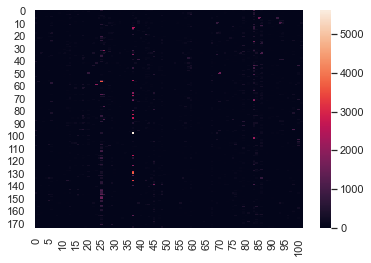

In [24]:
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(A)

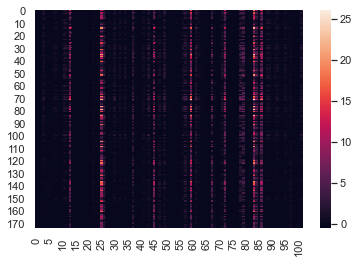

In [31]:
ax = sns.heatmap(L[:,:])

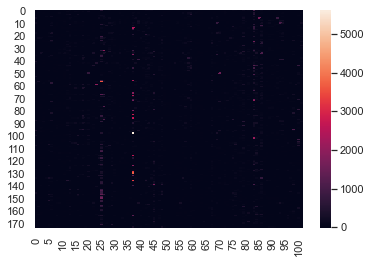

In [32]:
ax = sns.heatmap(S)